1.Import packages

In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import random
import datetime
import time
#from zfel import sase1d_input_part
import sase1d_input_part
import torch
import torch.optim as optim

2.Input parameters

In [22]:
Nruns=1                             # Number of runs
npart   = 512                       # n-macro-particles per bucket 
s_steps = 31#200#31                    # n-sample points along bunch length
z_steps = 20#200#20                    # n-sample points along undulator
energy  = 4313.34*1E6               # electron energy [eV]
eSpread = 0#1.0e-4                  # relative rms energy spread [ ]
emitN   = 1.2e-6                    # normalized transverse emittance [m-rad]
currentMax = 3900                   # peak current [Ampere]
beta = 26                           # mean beta [meter]
unduPeriod = 0.03                   # undulator period [meter]
#unduK = 3.5                        # undulator parameter, K [ ]
unduK = np.ones(z_steps)*3.5  # tapered undulator parameter, K [ ]
if unduK.shape[0]!=z_steps:
    print('Wrong! Number of steps should always be the same as z_steps')
unduL = 70#30                       # length of undulator [meter]
radWavelength = 1.5e-9              # seed wavelength? [meter], used only in single-freuqency runs
dEdz = 0                            # rate of relative energy gain or taper [keV/m], optimal~130
iopt = 'sase'                       # 'sase' or 'seeded'
P0 = 10000*0.0                      # small seed input power [W]
constseed = 1                       # whether we want to use constant random seed for reproducibility, 1 Yes, 0 No
particle_position=genfromtxt('./Inputs/particle_position.csv', delimiter=',') # or None  
# particle information with positions in meter and eta,\
# if we want to load random particle positions and energy, then set None
hist_rule='square-root'             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                    #  of intervals to generate the histogram of eta value in a bucket

In [23]:
'''
Put input parameters into a inp_struct dict, for 1D FEL run
'''
inp_struct={'Nruns':Nruns,'npart':npart,'s_steps':s_steps,'z_steps':z_steps,'energy':energy,'eSpread':eSpread,\
            'emitN':emitN,'currentMax':currentMax,'beta':beta,'unduPeriod':unduPeriod,'unduK':unduK,'unduL':\
            unduL,'radWavelength':radWavelength,'dEdz':dEdz,'iopt':iopt,'P0':P0,'constseed':constseed,'particle_position':particle_position,'hist_rule':hist_rule}

3.1D FEL run

Method 1: allow exploring all taper values

In [54]:
%load_ext autoreload
%autoreload

unduK = np.ones(z_steps)*3.5 #np.arange(3.52,3.48,-0.04/(z_steps-1))#   # tapered undulator parameter, K [ ]
if unduK.shape[0]!=z_steps:
    print('Wrong! Number of steps should always be the same as z_steps')
#unduK_1=torch.tensor(unduK[:int(z_steps/2)],dtype=torch.float64)
#unduK_2=torch.tensor(unduK[int(z_steps/2):],dtype=torch.float64,requires_grad=True)
unduK_1=torch.tensor(unduK[:int(z_steps/2)],dtype=torch.float64)
unduK_2=torch.tensor(unduK[int(z_steps/2):int(z_steps/2)+1],dtype=torch.float64,requires_grad=True)
unduK_3=torch.tensor(unduK[int(z_steps/2)+1:],dtype=torch.float64)
#unduK = torch.tensor(unduK, dtype=torch.float64, requires_grad=True)
#undu_K=torch.cat((unduK_1,unduK_2))
#params_K = unduK
#learning_rate = 5e-21
#optimizer = optim.SGD([unduK_2], lr=learning_rate)
#lr = 5e-21*torch.arange(unduK_2.shape[0])**4
lr = 5e-21
n_epochs = 3000
his_FEL_power=[]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def training_loop(n_epochs, lr, unduK_1, unduK_2, unduK_3, his_FEL_power):
    for epoch in range(1, n_epochs + 1):
        print('epochs:',epoch)
        lr=lr/2
        '''
        Use sase function in sase1d.py to run 1D FEL
        '''
        #with torch.autograd.set_detect_anomaly(True):
        #inp_struct['unduK']=params_K
        if unduK_2.grad is not None:
            unduK_2.grad.zero_()
        undu_K=torch.cat((unduK_1,unduK_2,unduK_3))
        inp_struct['unduK']=undu_K
        z,power_z,s,power_s,rho,detune,field,\
        field_s,gainLength,resWavelength,\
        thet_out,eta_out,bunching,spectrum,freq,\
        Ns,history=sase1d_input_part.sase(inp_struct)
        power_z[-1].backward()
        print('gradient',unduK_2.grad)
        print('power', power_z[-1])
        unduK_2=(unduK_2 - lr * \
            unduK_2.grad).detach().requires_grad_()
        
        #optimizer.zero_grad()
        #power_z[-1].backward()
        #optimizer.step()
        #print('gradient',unduK_2.grad)
        
        his_FEL_power.append(power_z[-1].detach().numpy())
    undu_K=torch.cat((unduK_1,unduK_2,unduK_3))
    return undu_K, his_FEL_power

epochs: 1
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-1.5772e+19], dtype=torch.float64)
power tensor(2.2119e+13, grad_fn=<SelectBackward>)
epochs: 2
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5394, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([6.0634e+17], dtype=torch.float64)
power tensor(2.6484e+13, grad_fn=<SelectBackward>)
epochs: 3
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5387, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([-7.4969e+17], dtype=torch.float64)
power tenso

gradient tensor([3.8206e+18], dtype=torch.float64)
power tensor(2.1668e+13, grad_fn=<SelectBackward>)
epochs: 25
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5411, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([3.8206e+18], dtype=torch.float64)
power tensor(2.1668e+13, grad_fn=<SelectBackward>)
epochs: 26
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5411, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dtype=torch.float64, grad_fn=<CatBackward>)
gradient tensor([3.8206e+18], dtype=torch.float64)
power tensor(2.1668e+13, grad_fn=<SelectBackward>)
epochs: 27
undu tensor([3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5411, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000,
        3.5000, 3.5000], dty

KeyboardInterrupt: 

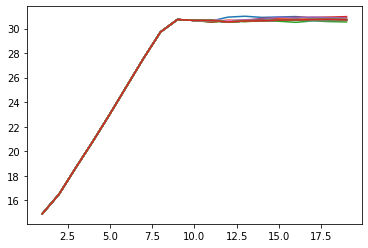

In [56]:
undu_K, his_FEL_power= training_loop(
    n_epochs = n_epochs,
    lr       = lr,
    #optimizer = optimizer,
    unduK_1 = unduK_1,
    unduK_2 = unduK_2,
    unduK_3 = unduK_3,
    his_FEL_power = his_FEL_power)

Text(0.5, 1.0, 'output FEL power vs. epochs')

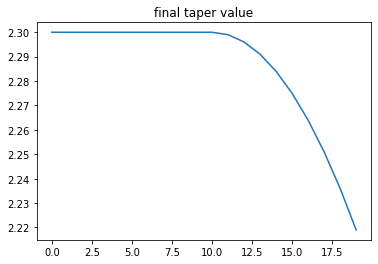

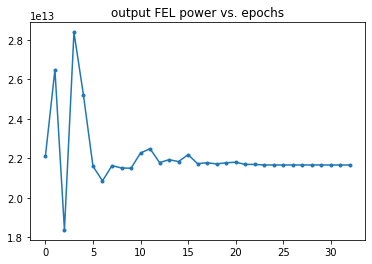

In [57]:
plt.figure()
plt.plot(undu_K.detach().numpy())
plt.title('final taper value')
plt.figure()
plt.plot(his_FEL_power,'.-')
plt.title('output FEL power vs. epochs')

Method 2: fit to quadratic taper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


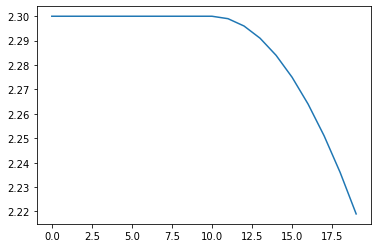

In [19]:
%load_ext autoreload
%autoreload


#params_K=torch.tensor([2.3,-0.001],requires_grad=True)
const_K=torch.tensor(2.3,requires_grad=True)
param_K=torch.tensor(-0.001+1e-7,requires_grad=True)
lr_const = 1e-6 #1e-17
lr_param = 1e-8#1e-21
#optimizer = optim.SGD([params_K], lr=learning_rate)
n_epochs = 100
his_FEL_power=[]
unduK_1=const_K*torch.ones(int(z_steps/2))
unduK_2=const_K+param_K*torch.arange(z_steps-int(z_steps/2))**2
undu_K=torch.cat((unduK_1,unduK_2))
plt.plot(undu_K.detach().numpy())

In [20]:
def training_loop(n_epochs, const_K, param_K, lr_const, lr_param, z_steps, his_FEL_power):
    for epoch in range(1, n_epochs + 1):
        print('epochs:',epoch)
        '''
        Use sase function in sase1d.py to run 1D FEL
        '''
        if const_K.grad is not None:
            const_K.grad.zero_()
        if param_K.grad is not None:
            param_K.grad.zero_()
        #sase1d_input_part.sase().zero_grad()
        #with torch.autograd.set_detect_anomaly(True):
        #inp_struct['unduK']=params_K
        #if unduK_2.grad is not None:
        #    unduK_2.grad.zero_()
        unduK_1=const_K*torch.ones(int(z_steps/2))
        unduK_2=const_K+param_K*torch.arange(z_steps-int(z_steps/2))**2
        undu_K=torch.cat((unduK_1,unduK_2))
        inp_struct['unduK']=undu_K
        z,power_z,s,power_s,rho,detune,field,\
        field_s,gainLength,resWavelength,\
        thet_out,eta_out,bunching,spectrum,freq,\
        Ns,history=sase1d_input_part.sase(inp_struct)
        
        
        #optimizer = optim.SGD([params_K], lr=lr)
        #optimizer.zero_grad()
        if epoch==1:
            (-power_z[-1]/1e13).backward(retain_graph=True)
        else:
            (-power_z[-1]/1e13).backward()
        print('gradient',const_K.grad,param_K.grad)
        const_K=(const_K + lr_const * const_K.grad).detach().requires_grad_()
        param_K=(param_K + lr_param * param_K.grad).detach().requires_grad_()
        #optimizer.step()
        
        print('power',power_z[-1])
        
        his_FEL_power.append(power_z[-1].detach().numpy())
    unduK_1=const_K*torch.ones(int(z_steps/2))
    unduK_2=const_K+param_K*torch.arange(z_steps-int(z_steps/2))**2
    undu_K=torch.cat((unduK_1,unduK_2))
    return undu_K, his_FEL_power

epochs: 1
undu tensor([2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000, 2.3000,
        2.3000, 2.3000, 2.2990, 2.2960, 2.2910, 2.2840, 2.2750, 2.2640, 2.2510,
        2.2360, 2.2190], grad_fn=<CatBackward>)
gradient tensor(902.6895) tensor(151356.0312)
power tensor(3.5847e+13, grad_fn=<SelectBackward>)
epochs: 2
undu tensor([2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009,
        2.3009, 2.3009, 2.3014, 2.3030, 2.3055, 2.3091, 2.3137, 2.3194, 2.3261,
        2.3338, 2.3425], grad_fn=<CatBackward>)
gradient tensor(22.5313) tensor(6775.4424)
power tensor(7.3745e+12, grad_fn=<SelectBackward>)
epochs: 3
undu tensor([2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009, 2.3009,
        2.3009, 2.3009, 2.3015, 2.3033, 2.3062, 2.3102, 2.3155, 2.3219, 2.3294,
        2.3381, 2.3480], grad_fn=<CatBackward>)
gradient tensor(16.0911) tensor(119.6851)
power tensor(9.7652e+12, grad_fn=<SelectBackward>)
epochs: 4
undu tensor([2.3009, 2.3009, 2.3009, 

KeyboardInterrupt: 

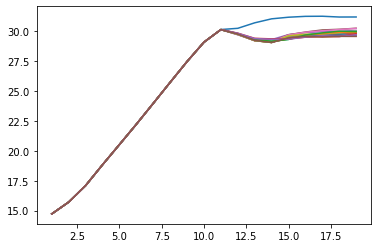

In [21]:
undu_K, his_FEL_power= training_loop(
    n_epochs = n_epochs,
    const_K = const_K,
    param_K = param_K,
    lr_const = lr_const,
    lr_param = lr_param,
    z_steps = z_steps,
    his_FEL_power = his_FEL_power)

Text(0.5, 1.0, 'output FEL power vs. epochs')

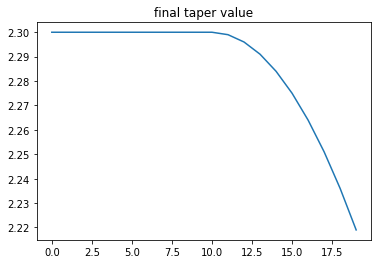

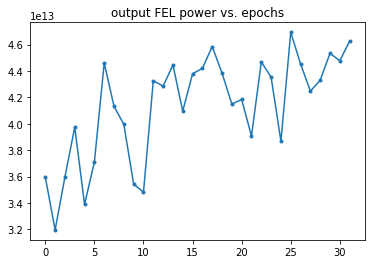

In [38]:
plt.figure()
plt.plot(undu_K.detach().numpy())
plt.title('final taper value')
plt.figure()
plt.plot(his_FEL_power,'.-')
plt.title('output FEL power vs. epochs')